In [550]:
from music21 import *
import copy, random, math

class MelodyModifier:
    def __init__(self, sc: stream.Score):
        '''
        Takes as input a path to a score
        '''
        self.sc = sc
        self.melody = self.sc.parts[0]
        self.melody.show()
        self.UNIT = 3

    def mutate_melody(self, tonic: pitch.Pitch) -> stream.Part():
        '''
        given a melody, change it as appropriate. then return that melody.
        '''
        self.staccato_short(0.5)
        self.accent_downbeat()
        
        # self.double_note_frequency(tonic)
        self.elevate_repeats(tonic)
        
        self.rand_chords(tonic)
        
        # self.chord_it(tonic)
        # self.grace_beginners(tonic)

    # Articulation modifications
    def staccato_short(self, min_dur: float):
        '''
        make all sufficiently-short notes in the melody staccato.
        '''
        for n in self.melody[note.Note]:
            if n.quarterLength <= min_dur:
                n.articulations += [articulations.Staccato()]
    def accent_downbeat(self):
        '''
        given a melody, accent every downbeat of the measures of the melody.
        '''
        accent = False
        for i, m in enumerate(self.melody[stream.Measure]):
            if i % self.UNIT == 0:
                accent = random.choice([True, False])
            if not accent: continue
            for n in m[note.Note]:
                if n.offset == 0:
                    n.articulations += [articulations.Accent()]

    def grace_beginners(self, tonic: pitch.Pitch, offset_desired=2):
        '''
        given a melody, add a grace note to downbeat notes of measures
        '''
        sc = scale.MajorScale(tonic.name)
        grace = False
        for i, m in enumerate(self.melody[stream.Measure]):
            if i % self.UNIT == 0:
                grace = random.choice([True, False])            
            if not grace: continue
            for n in m[note.Note]:
                if n.offset == offset_desired:
                    grace_start = note.Note(sc.nextPitch(n.nameWithOctave))
                    grace = grace_start.getGrace()
                    m.insert(0, grace)
    
    # Involvement
    def double_note_frequency(self, tonic: pitch.Pitch):
        '''
        given a melody, change each note to have two notes, each with double the frequency
        '''
        double = False
        for i, m in enumerate(self.melody[stream.Measure]):
            if i % self.UNIT == 0:
                double = random.choice([True, False])         
            if not double: continue
            for n in m[note.Note]:
                n.quarterLength *= 0.5
                n1 = copy.deepcopy(n)
                off = n.offset + n.quarterLength
                m.insert(off, n1)

    def elevate_repeats(self, tonic: pitch.Pitch, offset_mult=4):
        '''
        given a melody, for every note which starts a measure or a given offset
        multiplier (default 4: start of a 4/4 measure), change that note
        to have the next note up for the last 1/4 duration.
        
        Inspired by Country Gardens.
        
        C(4)-C(4) becomes C(3)-D(1)-C(4); parentheses illustrate durations.
        '''
        
        sc = scale.MajorScale(tonic.name)
        elevate = False
        for i, m in enumerate(self.melody[stream.Measure]):
            if i % self.UNIT == 0:
                elevate = random.choice([True, False, False])       
            if not elevate: continue
            for n in m[note.Note]:
                if n.offset % offset_mult == 0:
                    dur = n.quarterLength
                    n.quarterLength = 0.75 * dur
                    add_note = note.Note(sc.nextPitch(n.nameWithOctave))
                    add_note.quarterLength = 0.25 * dur
                    m.insert(n.offset + 0.75*dur, add_note)
    
    # Stacking
    def chord_it(self, tonic: pitch.Pitch, is_above=False):
        '''
        given a melody, take the first note of each measure and turn that into a chord
        '''
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                chord_notes = []
                if n.offset == 0:
                    pitch_nums = [2, 4, 7]
                    for i in range(3):
                        new_note = note.Note(sc.nextPitch(n.nameWithOctave, stepSize=pitch_nums[i]).nameWithOctave)
                        new_note.quarterLength = n.quarterLength
                        if not is_above:
                            new_note.octave -= 1 if new_note.name != n.name else 2
                        chord_notes.append(new_note)
                    new_chord = chord.Chord(chord_notes, duration=n.duration)
                    m.insertIntoNoteOrChord(0, new_chord)
    
    def rand_chords(self, tonic: pitch.Pitch, is_above=False, chord_density=0.44, note_density=0.4):
        '''
        allow random chords to accompany notes; this is specifically for non-downbeat chords
        '''
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                chord_notes = []             
                if n.offset != 0 and random.random() <= chord_density:
                    pitch_nums = [2, 4, 7]
                    for i in range(3):
                        if random.random() <= note_density:
                            new_note = note.Note(sc.nextPitch(n.nameWithOctave, stepSize=pitch_nums[i]).nameWithOctave)
                            new_note.quarterLength = n.quarterLength
                            if not is_above:
                                new_note.octave -= 1 if new_note.name != n.name else 2
                            chord_notes.append(new_note)
                    new_chord = chord.Chord(chord_notes, duration=n.duration)
                    m.insertIntoNoteOrChord(n.offset, new_chord)



In [511]:
def beat_strength(offset: float) -> int:
    # Returns 2 if on 1, 3
    # 1 if on 2, 4
    # 0 if on +
    beat = math.floor(offset)
    decimal = offset - beat
    if decimal == 0:
        return 2 if beat in [0, 2] else 1
    else:
        return 0
    
def next_chord_tone(p: pitch.Pitch, ch: chord.Chord) -> pitch.Pitch:
    next_map = {
        ch.root().pitchClass: ch.third,
        ch.third.pitchClass: ch.fifth,
        ch.fifth.pitchClass: ch.root(),
    }
    res = next_map[p.pitchClass].transposeAboveTarget(p)
    if res.midi == p.midi:
        res.octave += 1
    return res

def prev_chord_tone(p: pitch.Pitch, ch: chord.Chord) -> pitch.Pitch:
    prev_map = {
        ch.root().pitchClass: ch.fifth,
        ch.third.pitchClass: ch.root(),
        ch.fifth.pitchClass: ch.third,
    }
    res = prev_map[p.pitchClass].transposeBelowTarget(p)
    if res.midi == p.midi:
        res.octave -= 1
    return res

def chord_tones_above(p: pitch.Pitch, ch: chord.Chord, k: int) -> list[pitch.Pitch]:
    '''
    Return the k chord tones above and including p.
    '''
    res = [p]
    for _ in range(k - 1):
        res.append(next_chord_tone(res[-1], ch))
    return res

def clear_range(m: stream.Measure, start: float, end: float):
    to_remove = [elem for elem in m if start <= elem.offset < end]
    for elem in to_remove:
        print("Removing", elem)
        m.remove(elem)

In [537]:
class BassModifier:
    def __init__(self, sc: stream.Score):
        '''
        Takes as input a path to a score which contains the chord labels
        '''
        self.sc = sc
        self.UNIT = 3
        self.bassline = self.sc.parts[1]
        self.key_sig = self.bassline[key.KeySignature].first()
        self.scale = self.key_sig.getScale('major')
        self.chords = {}
        self.notes = {}
        # TODO: music21 is very buggy with remove :|, so I just deduce the chords manually... 
        for n in self.bassline.flatten()[note.Note]:
            self.notes[n.offset] = n
            p = n.pitch
            self.chords[n.offset] = chord.Chord(
                [p, self.scale.nextPitch(p, stepSize=2), self.scale.nextPitch(p, stepSize=4)],
                duration=n.duration
            )
        self.measures = self.bassline[stream.Measure]
    
    
    def set_rhythm(self, n: note.Note, pattern: list[int]):
        '''
        Modifies a notes rhythm (where it is in a measure's context)
        '''
        d = n.quarterLength
        m = self.bassline.measure(n.measureNumber)
        curr_offset = n.offset # - m.offset
        # print("Starting at", offset, m.offset, n.measureNumber)
        denom = sum(pattern)
        for ix, amt in enumerate(pattern):
            new_d = amt / denom * d
            # print("Inserting", new_d, "at", curr_offset)
            if ix == 0:
                n.quarterLength = new_d
            else:
                new_n = note.Note(n.pitch, duration=duration.Duration(new_d))
                m.insert(curr_offset, new_n)
            curr_offset += new_d

    def inject_rhythm(self):
        '''
        For a loop of n chords, choose two patterns, one for first n-1, and a different
        one for the nth (to give rhythmic drive to the next loop)
        
        Currently, breaks into half-note divisions and provides one of the following
        distributions: 
        3:3:2, 3:1, 2:2, 1:1:1:1, 2:1:1, 1:1:2
        
        Operate on each half note first. Then organize which ones are special

        Todo: make more decisions on the weighting.
        '''
        # n = len(self.bassline.measures())
        # First pattern for the first n-1 measures
        weights = random.choice([
            [4, 3, 4, 2, 6, 5],
            [4, 3, 1, 5, 4, 2],
            # [1, 1, 1, 5, 1, 1], # Straight arpeggio
            # [0, 0, 0, 5, 1, 1], # Straight arpeggio
            [1, 1, 1, 0, 0, 0],
        ])
        choices = [
            [3, 3, 2],
            [3, 1],
            [1, 1],
            [1, 1, 1, 1],
            [2, 1, 1],
            [1, 1, 2],
        ]
        rhythm_pattern = random.choices(choices, weights=weights, k=2)
        for i, m in enumerate(self.measures):
            if i % self.UNIT == 0:
                rhythm_pattern = random.choices(choices, weights=weights, k=2)
            
            if i % self.UNIT < self.UNIT - 1:
                # Divide it by 2
                for n in m[note.Note]:
                    initial_split = [[1], [1, 1], [1, 1]] # Consider not splitting at all to slow it down
                    if n.quarterLength == 4:
                        self.set_rhythm(n, random.choice(initial_split))
                for n in m[note.Note]:
                    self.set_rhythm(n, rhythm_pattern[0])
            else:
                for n in self.measures[i][note.Note]:
                    self.set_rhythm(n, rhythm_pattern[1])

    def arpeggiate(self):
        '''
        Set more diverse pitches for the rhythms
        '''
        # Randomly shift by amounts. 
        weights = random.choice([
            [4, 3, 2, 3, 1],
            [2, 2, 1, 1, 0],
            [1, 1, 0, 0, 0],
            [1, 0, 1, 1, 0],
            [1, 0, 0, 1, 0]
        ])
        choices = [
            0, 1, 2, 3, 4 # Root, 3rd, 5th, 8th, 10th for now.
        ]
        arpeggio_pattern = [0] + random.choices(choices, weights=weights, k=3)
        curr_chord = self.chords[0]
        chord_tones = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
        pattern_pos = 0

        for i, m in enumerate(self.measures):
            if i % self.UNIT == 0:
                arpeggio_pattern = [0] + random.choices(choices, weights=weights, k=3)

            for n in m[note.Note]:
                curr_offset = m.offset + n.offset 
                if curr_offset in self.chords:
                    curr_chord = self.chords[curr_offset]
                    chord_tones = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
                    pattern_pos = 0

                # TODO: Maybe consider strong vs weak beats?
                # Cycle through the pattern for the current chord
                n.pitch = chord_tones[arpeggio_pattern[pattern_pos]]
                pattern_pos = (pattern_pos + 1) % len(arpeggio_pattern)

    def thicken(self):
        '''
        Expand the notes to contain more chords, upwards
        '''
        # Randomly thicken
        weights = random.choice([
            [1, 1, 1, 1],
            [2, 1, 0, 0],
            [1, 1, 0, 0]
        ])
        choices = [
            0, 1, 2, 3 # Allow stacking from 0 to 3 notes above the bass.
        ]
        thickness_pattern = random.choices(choices, weights=weights, k=4)
        curr_chord = self.chords[0] # Start with the root guaranteed
        pattern_pos = 0

        for i, m in enumerate(self.measures):
            if i % self.UNIT == 0:
                thickness_pattern = random.choices(choices, weights=weights, k=4)
                
            for n in m[note.Note]:
                curr_offset = m.offset + n.offset 
                if curr_offset in self.chords:
                    curr_chord = self.chords[curr_offset]
                    pattern_pos = 0

                thickness = thickness_pattern[pattern_pos]
                if thickness > 0:
                    chord_stack = chord_tones_above(n.pitch, curr_chord, len(choices))
                    stack = [chord_stack[1 + i] for i in range(thickness)]
                    if random.random() <= 0.2 * thickness: # Thinning chords by removing the extra notes with some prob
                        stack.pop(0)
                    # print("Inserting at", n.offset, *m.getElementsByOffset(n.offset), n.pitch, stack)
                    m.insertIntoNoteOrChord(n.offset, chord.Chord(stack, quarterLength=n.quarterLength))

                pattern_pos = (pattern_pos + 1) % len(thickness_pattern)


    def get_approach_tones(self, prev: pitch.Pitch, curr: pitch.Pitch):
        '''
        Returns the approach tones in order from nearest the goal, to farthest
        '''
        choices = [[], [2], [-2], [1], [-1], [1, 1], [-1, -1]]
        # Chromatic approach: nothing, one 8th, or two 16ths.
        approach = []
        pattern = random.choice(choices)
        goal = curr
        for elem in pattern:
            ql = abs(elem) * 0.25
            shift = '-m2' if elem < 0 else 'm2'
            goal = goal.transpose(shift).simplifyEnharmonic()
            approach.append(note.Note(goal, quarterLength=ql))
        # Always add the previous octave as a transition element
        approach.append(note.Note(prev, quarterLength=0.25))
        return approach

    def insert_approach_tones(self):
        '''
        Override some of the previous rhythms with approach tones in front of new chords
        '''
        # Two main techniques:
        # Single or double approach chromatic.
        # Then, we can stack that by adding the current root

        '''
        Assume: no note stretches across measures.
        Only if the last note in a measure is >= a quarter, do we add the approach tones.
        
        Assuming the last note/rest goes to the end of bar.
        We'll shrink the last general item, then add approach tones
        '''
        original_notes = self.bassline[note.GeneralNote]
        for i in range(len(original_notes) - 1):
            curr_note, next_note = original_notes[i], original_notes[i + 1]
            if curr_note.measureNumber == next_note.measureNumber:
                continue
            ql = curr_note.quarterLength
            if ql < 1 or random.random() < 0.8: # Avoiding too 80% of the approach tones since it's too jazzy
                continue
            
            approach_tones = []
            from_pitch, to_pitch = None, None
            if isinstance(curr_note, chord.Chord):
                from_pitch = curr_note.root()
            elif isinstance(curr_note, note.Note):
                from_pitch = curr_note.pitch
            else:
                continue
            if isinstance(next_note, chord.Chord):
                to_pitch = next_note.root()
            elif isinstance(next_note, note.Note):
                to_pitch = next_note.pitch
            else:
                continue

            approach_tones =self.get_approach_tones(from_pitch, to_pitch)
            approach_length = sum(n.quarterLength for n in approach_tones)
            pos = curr_note.offset + curr_note.quarterLength
            curr_note.quarterLength -= approach_length

            # Instead of curr_note, we want the root of the current chord.
            for n in approach_tones:
                pos -= n.quarterLength
                m = self.bassline.measure(curr_note.measureNumber) 
                m.insert(pos, n)

    def mutate_bass(self):
        # print("Injecting rhythm")
        # self.bassline.show()
        self.inject_rhythm()
        # self.bassline.show()
        # print("Arpeggiating")
        self.arpeggiate()
        # self.bassline.show()

        # print("Thickening")
        self.thicken()
        # self.bassline.show()

        self.insert_approach_tones()
        # self.bassline.show()

In [532]:
class MusicModifier:
    def __init__(self, sc: stream.Score):
        self.sc = sc
        self.bm = BassModifier(self.sc)
        self.mm = MelodyModifier(self.sc)
    
    def modify(self):
        tonic = self.bm.key_sig.asKey().tonic
        self.bm.mutate_bass()
        self.mm.mutate_melody(tonic)
        
        # fix_accidentals(self.sc) # Don't think it'll work on chromatic steps

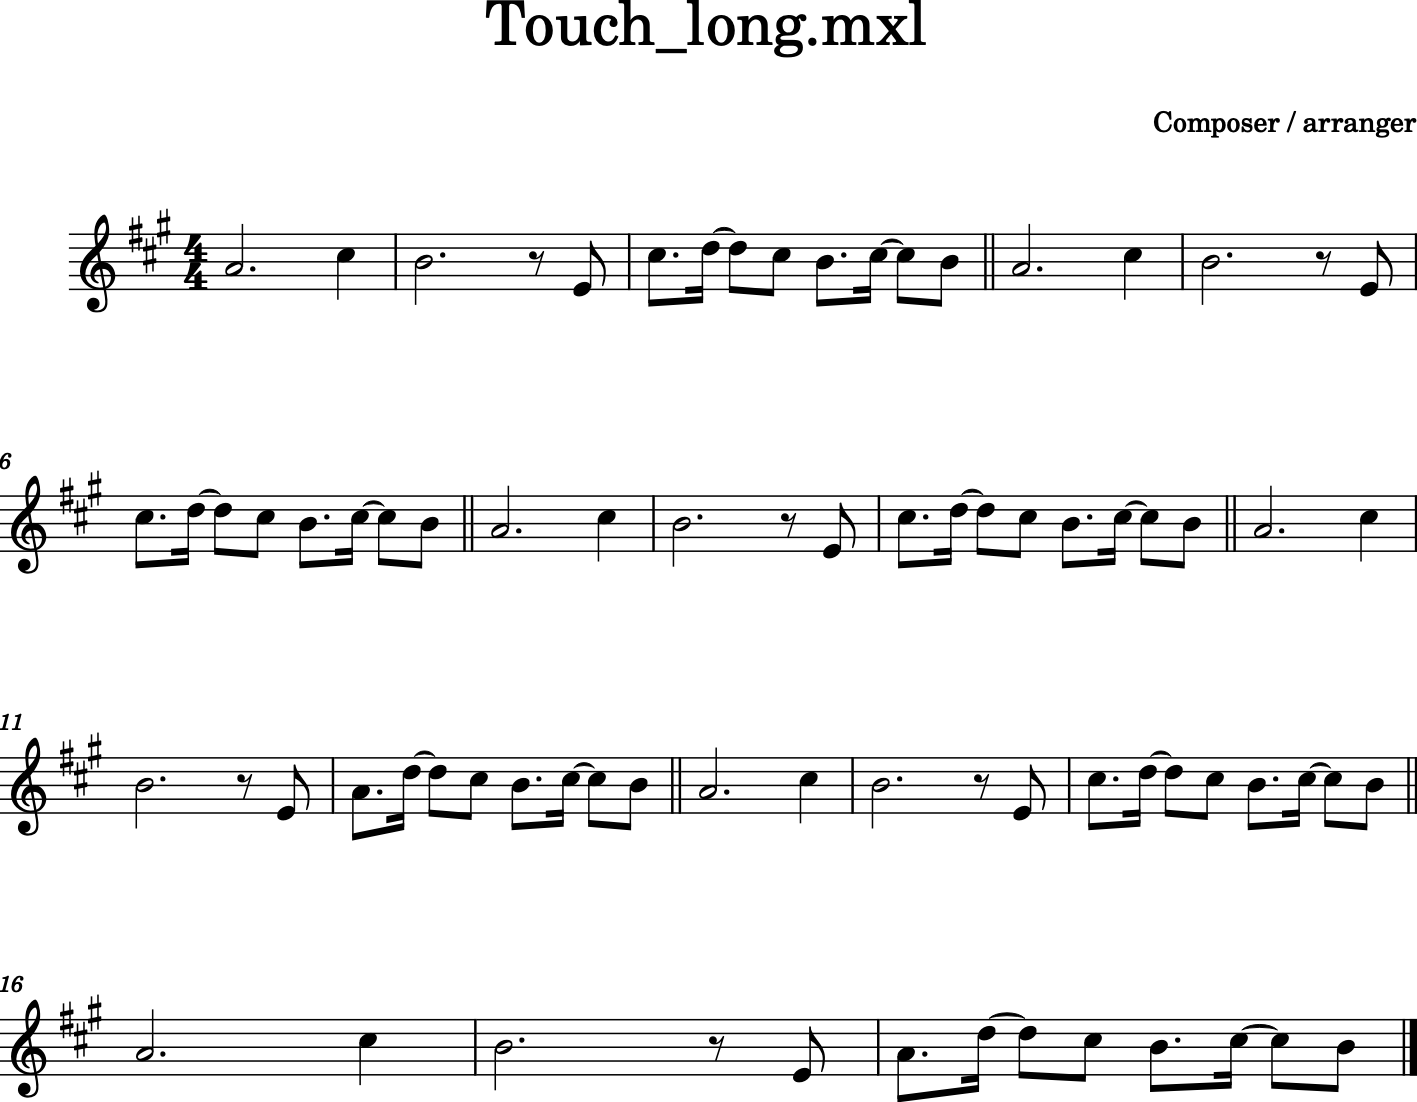

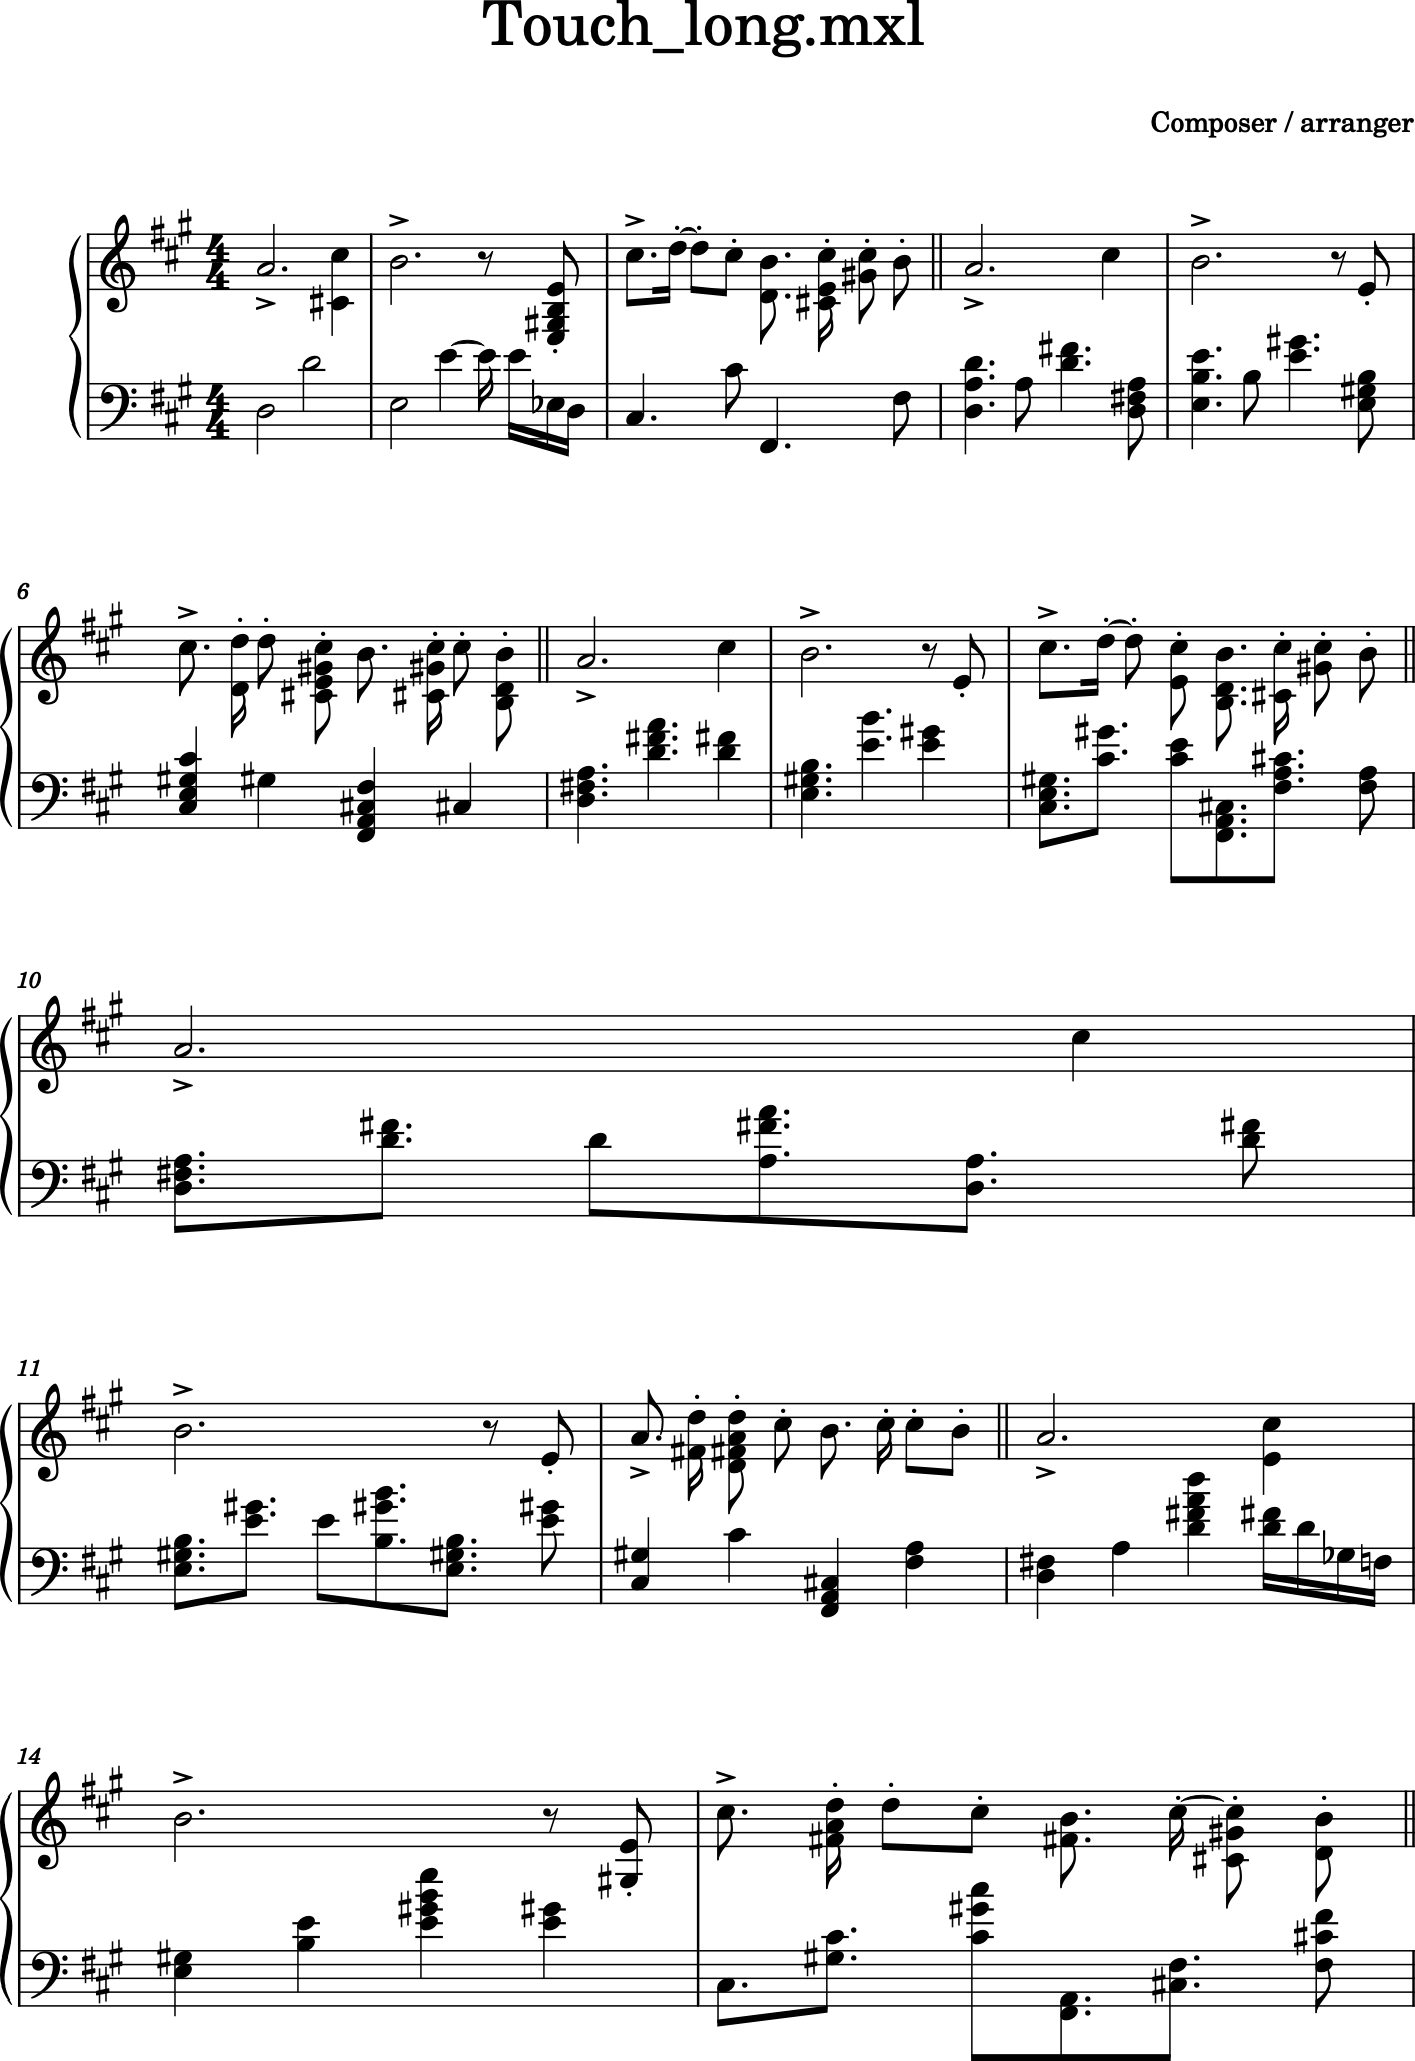

In [533]:
score_dir = '/Users/derrick/PycharmProjects/MIT/21M_383/music-melody-generator/scores/'
piece = "Touch_long.mxl"
sc = converter.parse(score_dir + piece)
modifier = MusicModifier(sc)
modifier.modify()
sc.show()

In [516]:
file_path = 'with_approach_touch_long_fixed_2.midi'
sc.write('midi', file_path)
sc.write('xml', 'with_approach_touch_long_fixed_2.mxl')

'with_approach_touch_long_fixed_2.midi'

PosixPath('/Users/derrick/Dropbox (MIT)/MIT Work/Junior/Spring/21M.383/music-melody-generator/with_approach_touch_long_fixed_2.mxl')

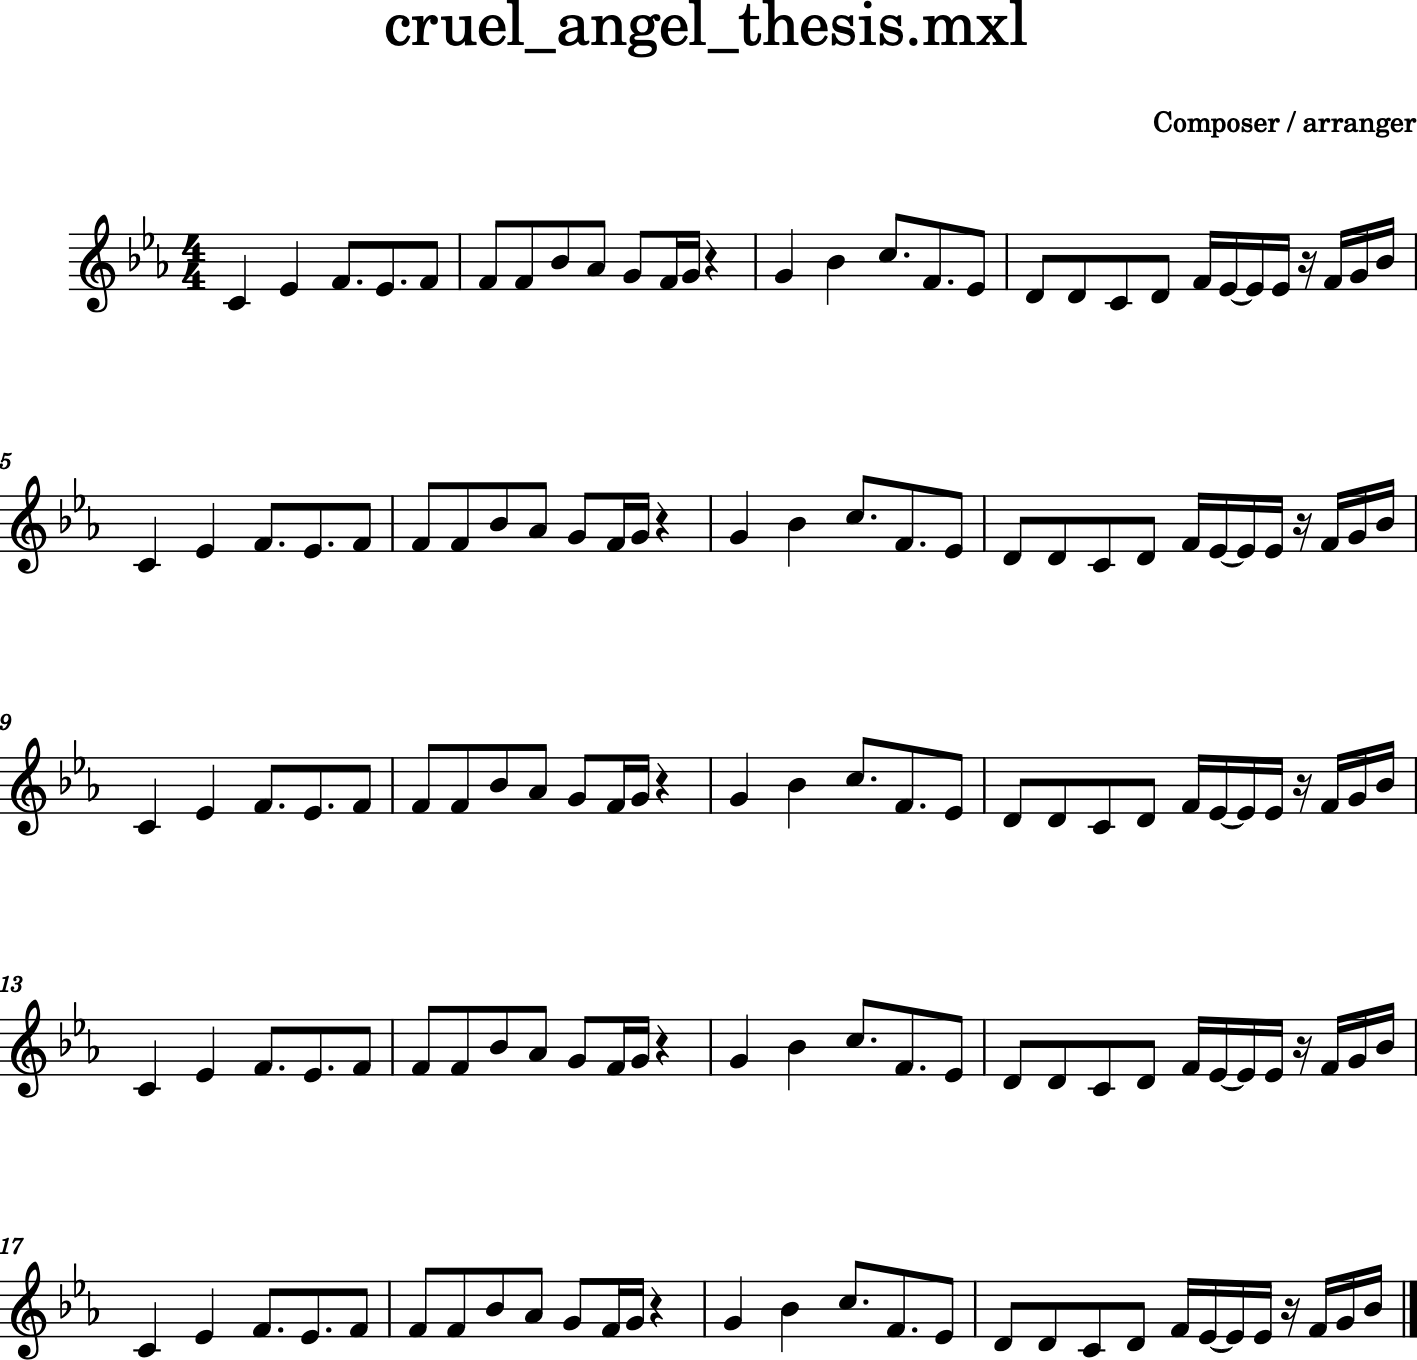

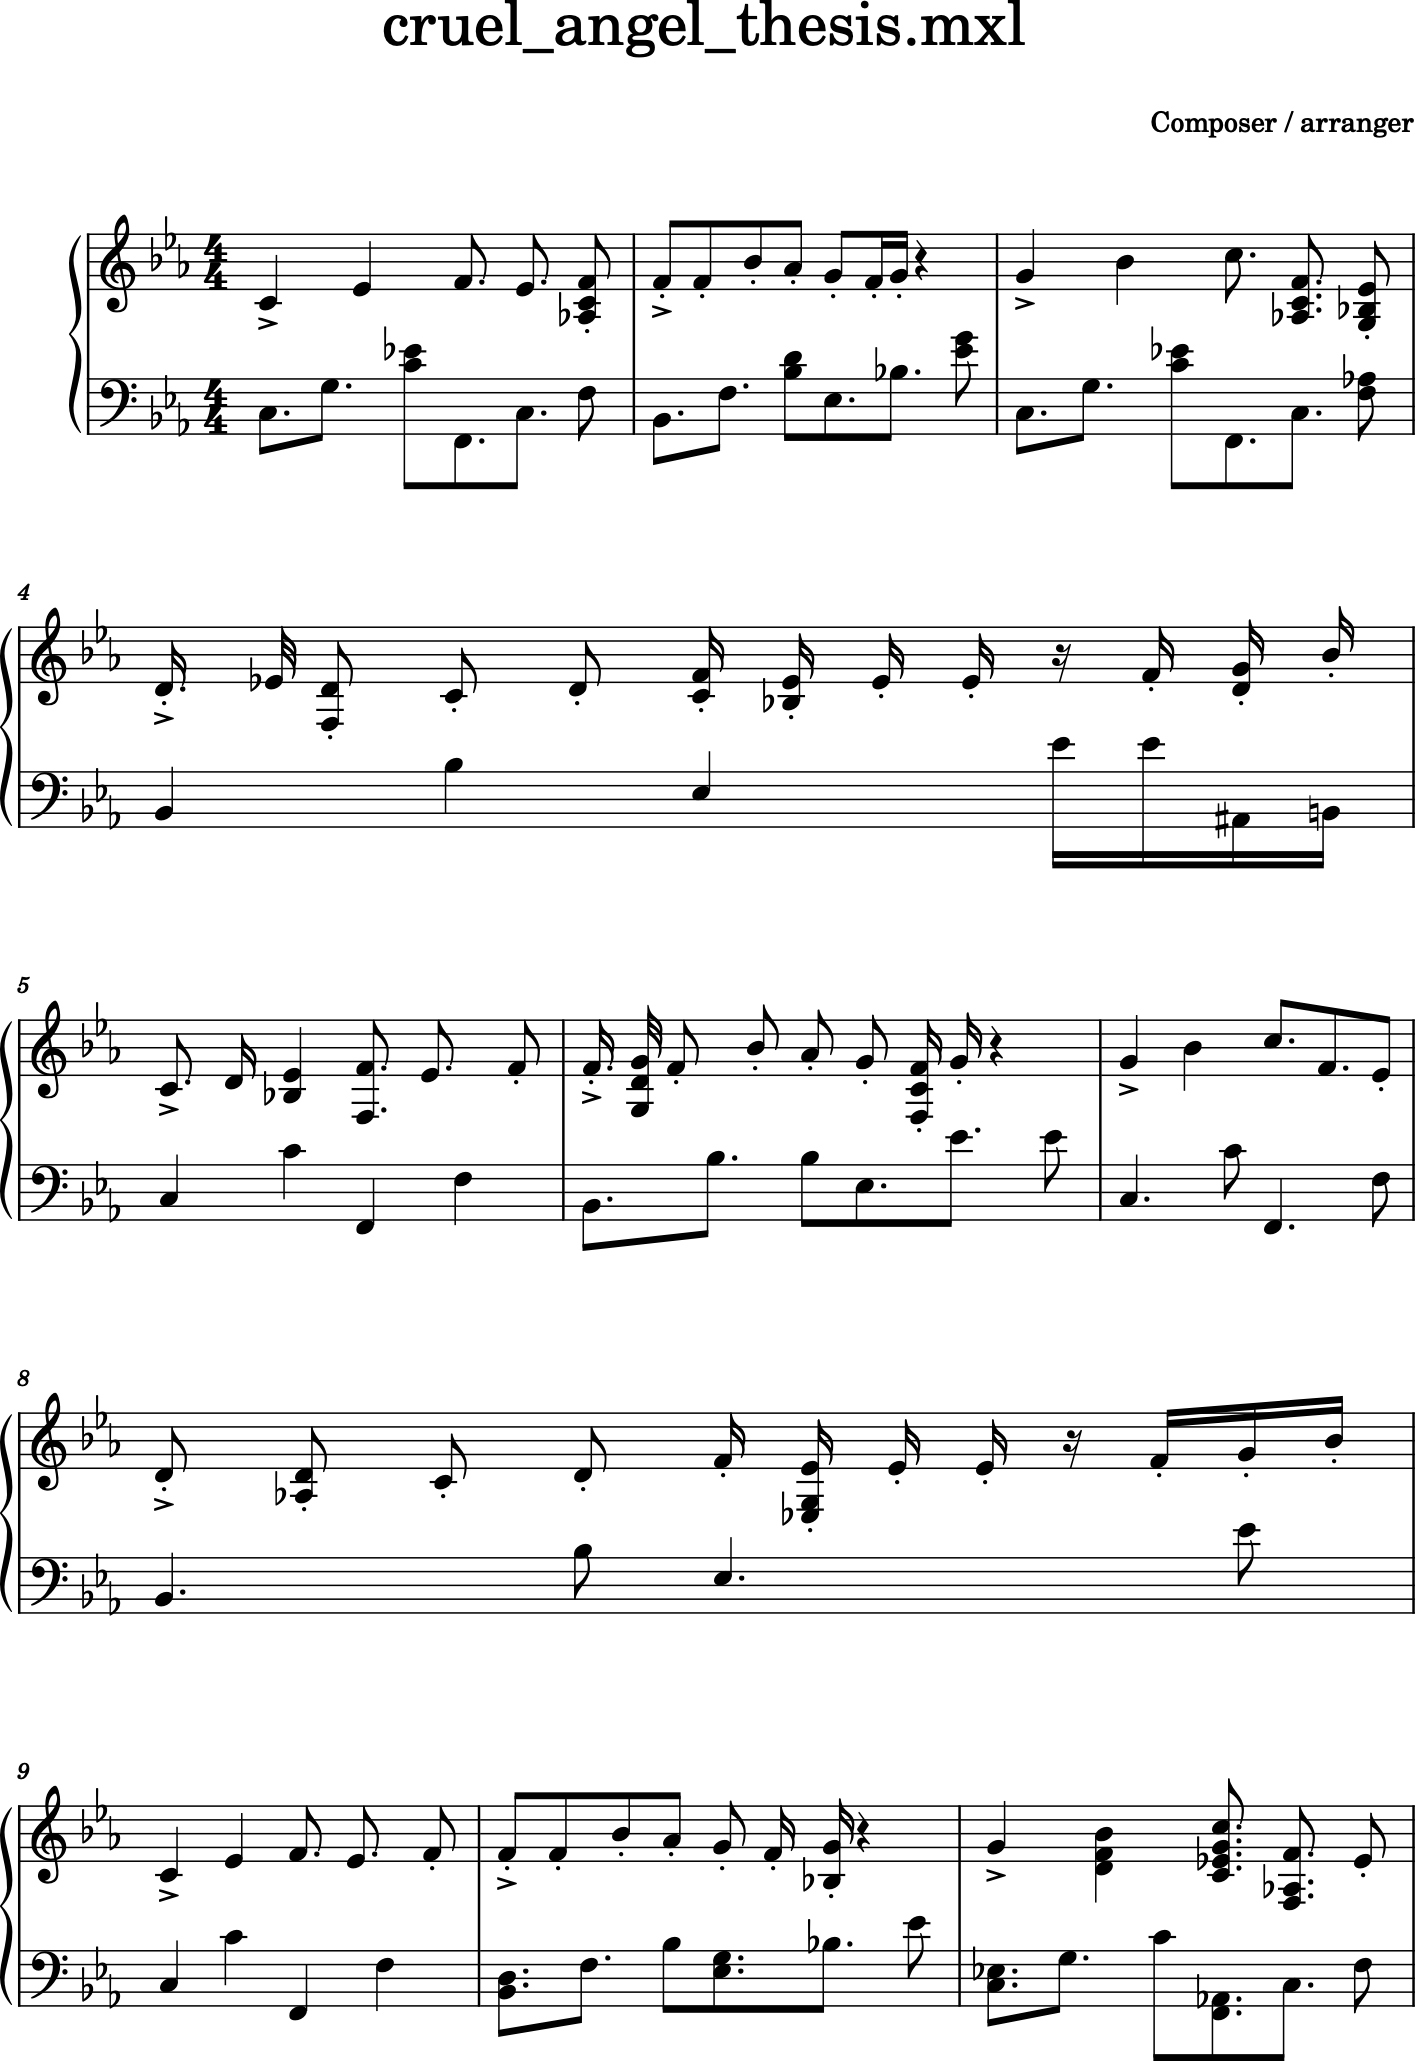

In [551]:
score_dir = '/Users/derrick/PycharmProjects/MIT/21M_383/music-melody-generator/scores/'
piece = "cruel_angel_thesis.mxl"
sc = converter.parse(score_dir + piece)
modifier = MusicModifier(sc)
modifier.modify()
sc.show()


In [552]:
file_path = 'thesis_3_1'
sc.write('midi', file_path + '.midi')
sc.write('xml', file_path + '.mxl')

PosixPath('/Users/derrick/Dropbox (MIT)/MIT Work/Junior/Spring/21M.383/music-melody-generator/thesis_3_1.mxl')